Brian Hanley

This notebook was made to test methods of solving a function of the form

**A\*v=b**

Where A is a tridiagonal matrix, b is a vector of known values, and v is a vector of variables. We will be solving for the values of v.

This stems from the solution for one-dimensional Poisson equation with Dirichlet boundary conditions using a set of linear equations, f(x). x can be any value between 0 and 1, with xi, the discrete steps of x values, equal to ih, where h is the size of our steps **(h=1/(n+1))**. The specific value f[i], which is f(x[i]), is equal to **-(v[i-1]+v[i+1]-2v[i])/h^2**. We can represent this using a matrix and vectors using the form above. We will say **b[i]=h^2\*f[i]**. We can also represent the values of v as a vector. Lastly by multiplying a tridiagonal matrix by the vector v, for each i value 

**b[i]=A[i]\[i-1\]v[i-1]+A[i]\[i\]v[i]+A[i]\[i+1\]v[i+1]**

which is equivalent to our stated function above. By making all values A[i]\[i\]=2, and all values A[i]\[i-1\]=A[i]\[i+1\]=-1 we can get the exact form that we stated earlier.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import scipy.linalg as alg

import time


The following two sections encompassess my algorithm. I developed this algorithm and the program implementing it based on the one I found [here](http://www.webpages.uidaho.edu/~barannyk/Teaching/LU_factorization_tridiagonal.pdf). First I do an LU decomposition on the tridiagonal matrix, treating each of the 3 diagonals as seperate arrays. The arrays will be labelled as follows: a for the lower diagonal, b for the center diagonal, and c for the upper diagonal. The L matrix will have a diagonal below the center diagonal. We will call the first value of this diagonal 0 and the subsequent values of L will be of the form 

**(1) L[i]=a[i]/U[i-1]**

The U matrix will have a diagonal of the form 

**(2) U[i] = b[i]-L[i]*c[i-1]**

with the first value being b1 because L1 is 0. There will be a second diagonal above the central one equal to the 'c' diagonal from the original matrix.



After decomposing the matrix we can start on the second part of the algorithm. We will be solving for x in the equation 

**(3) L\*U\*x=f**

where f is an array with each value 

**(4) fi = h^2 \* f(xi)**.

This is accomplished by breaking the problem into 2 parts and solving them in sequence. The first is 

**(5) L\*y= f**

where

**(6) y=U\*x**

which is the second equation we will be solving. For the first equation will be of the form 

**(7) y[i]=f[i]-L[i]\*y[i-1]**

with the first element of y being the first element of f. This feeds directly into the second equation, which we will solve from the end and solve backwards to the beginning. We will start with **x[n]=y[n]/U[n]** and then

**(8) x[n-i]=(y[n-i]-c[n-i]*x[n-i+1])/U[n-i]**

The 'x' array is our final solution and should map out a downward facing parabola that corresponds to a Poisson distribution of the solutions for the equation. 

In [2]:
def LU_decomp_tridiag(a,b,c):# a, b, and c are numpy array representations of the diagonals of matrix A
    
    n=len(b)
    
    u=np.array([b[0]])#Initialize U
    
    l=np.array([0])#Initialize L
    
    
    for i in range(1,n):
        
        l=np.append(l, a[i]/u[i-1]) # Equation (1)
        u=np.append(u, b[i]-l[i]*c[i-1])# Equation (2)
        
    return l,u

def LU_solver_tridiag(l,u,c,f):
    
    n= len(f)
    
    #Ly=f (Equation(5))
    
    y=np.array([f[0]])
    
    
    for i in range(1,n):
        
        y=np.append(y, f[i]-l[i]*y[i-1])#Equation (7)
    
    #Ux=y(Equation (6))
    
    x=np.zeros(n) #Initialize x
    x[-1]=y[-1]/u[-1]
    
    for k in range(2,n+1,1):
        
        x[-k]=(y[-k]-c[-k]*x[-k+1])/u[-k]# Equation (8)
        
    return x

In [3]:
def tridiagonal_lu_initializer_general(size):    
    
    # This function sets up our a, b, c, and f arrays based on the desired size 'n'.
    # To keep things simple and consistent right now our arrays will be mostly homogeneous with the
    # first value of a and the last value of c set to 0 to represent them 1. being offset from b & 2. being shorter than b.
    # f will be an array of all 1's to keep things simple for now. In later tests we can set it to a function value.
    
    a=np.zeros(size)
    a.fill(-1)
    a[0]=0

    b=np.zeros(size)
    b.fill(2)

    c=np.zeros(size)
    c.fill(-1)
    c[size-1]=0

    f=np.ones(size)
    
    return a,b,c,f

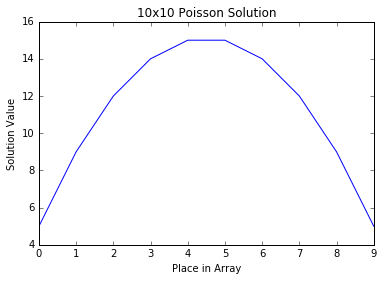

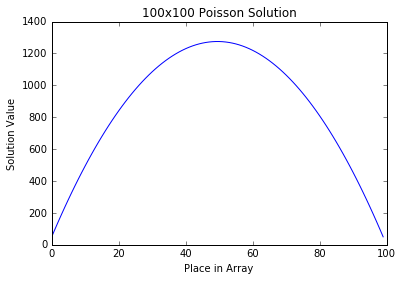

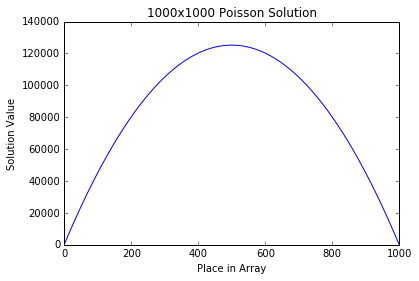

In [6]:
for i in range(1,4): # We will loop through 3 different size values of n: 10, 100, and 1000 and plot values of x versus its position
    
    n=10**i
    
    a,b,c,f=tridiagonal_lu_initializer_general(n)

    l,u=LU_decomp_tridiag(a,b,c)
    x=LU_solver_tridiag(l,u,c,f)
    
    
    plt.plot(x)
    plt.title(str(n)+"x"+str(n)+" Poisson Solution")
    plt.ylabel('Solution Value')
    plt.xlabel('Place in Array')
    plt.show()

**The Special Case**

The below cells use the same algorithm as the general case, but treat all values of a, b, and c as constant and thus do not have to iterate through multiple lists to find the answer. This should cut down on the runtime of the function.

In [12]:
def LU_decomp_tridiag_special(a,b,c,n):# a, b, and c are the values, n is the length of the matrix
    
    
    u=np.array([b])
    l=np.array([0])
    
    
    for i in range(1,n):
        
        l=np.append(l, a/u[i-1]) # Equation (1)
        u=np.append(u, b-l[i]*c) # Equation (2)
    return l,u

def LU_solver_tridiag_special(l,u,c,f,n):
    
    #Ly=f (Equation(5))
    
    y=np.array([f[0]])
    
    
    for i in range(1,n):
        
        y=np.append(y, f[i]-l[i]*y[i-1]) #Equation (7)
    
    #Ux=y (Equation(6))
    
    x=np.zeros(n)
    x[-1]=y[-1]/u[-1]
    
    for k in range(2,n+1,1):
        
        x[-k]=(y[-k]-c*x[-k+1])/u[-k] #Equation (8)
        
    return x

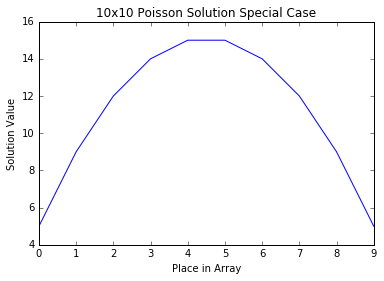

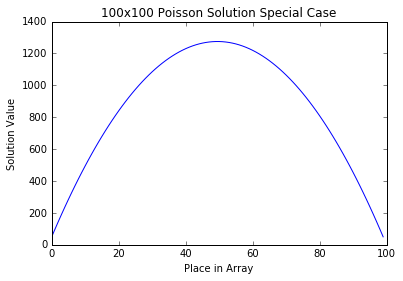

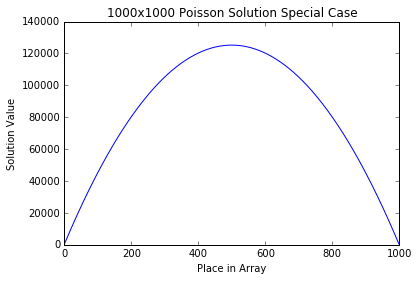

In [13]:
# As before, we will run these functions one matrices sized 10x10 to 1000x1000 and plot the results.
a=-1
b=2
c=-1

for i in range(1,4):
    
    n=10**i
    
    f=np.ones(n)
    
    l,u=LU_decomp_tridiag_special(a,b,c,n)
    x=LU_solver_tridiag_special(l,u,c,f,n)
    
    plt.plot(x)
    plt.title(str(n)+"x"+str(n)+" Poisson Solution Special Case")
    plt.ylabel('Solution Value')
    plt.xlabel('Place in Array')
    plt.show()

**Comparing the General to Special Case**

In the below section we will run both functions going over a range of sizes from 10 to 10,000. We will then take the run time of each function for each time, store it in an array, and graph it versus the size of the matrix/arrays. This will give us a good idea of which function is faster. It will not give us a wholly accurate version of the run time of either function as anything running in the background that takes up processing power and memory will increase the runtime, but the ratio of the runtimes should hold.

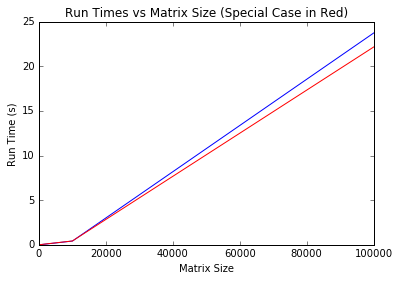

In [17]:
a=-1
b=2
c=-1

special_times=np.array([])

general_times=np.array([])

n_values=np.array([])

for i in range(1,6):
    
    n=10**i
    
    n_values=np.append(n_values,n)
    
    f=np.ones(n)
    
    #Special
    spec_start=time.time()
    
    l,u=LU_decomp_tridiag_special(a,b,c,n)
    x=LU_solver_tridiag_special(l,u,c,f,n)
    
    special_times=np.append(special_times,time.time()-spec_start)
    
    
    #General
    
    a_gen, b_gen, c_gen,  f_gen=tridiagonal_lu_initializer_general(n)
    
    gen_start=time.time()
    
    l,u=LU_decomp_tridiag(a_gen,b_gen,c_gen)
    x=LU_solver_tridiag(l,u,c_gen,f_gen)
    
    general_times=np.append(general_times,time.time()-gen_start)
    
plt.plot( n_values,general_times)
plt.plot(n_values,special_times,'r')

plt.title('Run Times vs Matrix Size (Special Case in Red)')
plt.ylabel('Run Time (s)')
plt.xlabel('Matrix Size')

As can be seen by running the above function, the special case functions will solve our problem faster than the general case function. This is to be expected because it deals with less arrays. There is, however, a variance in this result. If I try to browse the internet while I am letting the program run, then some runs will have my special case running much slower than the general case. I have done 10 seperate runs with just this window open and a minimal number of programs running in the background and the special case has consistently been faster than the general case in these runs.

**My Times vs Python Times**

In the below section we will compare the run times of our own special case function versus the SciPy functions 'lu_factor' and 'lu_solve'. The first function takes in a square matrix which I have created, and it breaks it up into a matrix, whose lower part is the 'L' matrix and whose upper part is the 'U' matrix, and a permutation array that contains information about any permutations that were performed on our initial matrix to factor it.

Our method for measuring the time will be the same as our method above and will only give us a comparison of the run times, not what each methods run time actually is.

In [15]:
def initialize_matrix(size):

    #Initialize matrix with all 0 values
    A=np.zeros((size,size))
    
    for i in range(len(A)):
        for j in range(len(A[i])):# Iterate through each value in the matrix
            
            if j==i:#if the value is on the main diagonal, set it to 2
                A[i][j]=2
                
            if j==i+1 or j==i-1:# if the value is on the diagonal on either side of the main diagonal set it to -1
                A[i][j]=-1
                
    return A

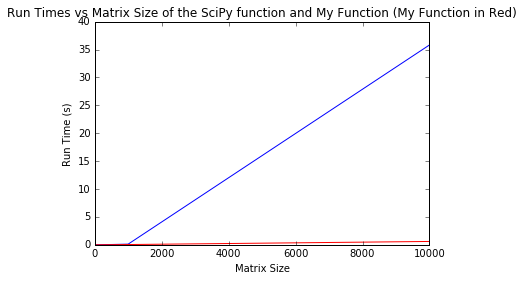

In [16]:
python_times=np.array([])

my_times=np.array([])

n_sizes=np.array([])


for i in range(1,5):#Iterate through sizes 10 to 10000 for each method and save the times
    n=10**i
    n_sizes=np.append(n_sizes,n)

    A=initialize_matrix(n)
    f=np.ones(n)
    
    start_pyth=time.time()

    lu,p=alg.lu_factor(A)
    x_python=alg.lu_solve((lu,p),f)
    
    python_times=np.append(python_times, (time.time()-start_pyth))


    start_my=time.time()
    
    l,u=LU_decomp_tridiag_special(-1,2,-1,n)
    x=LU_solver_tridiag_special(l,u,-1,f,n)
    
    my_times=np.append(my_times,time.time()-start_my)
    
    
plt.plot(n_sizes,python_times)
plt.plot(n_sizes,my_times,'r')

plt.title('Run Times vs Matrix Size of the SciPy function and My Function (My Function in Red)')
plt.ylabel('Run Time (s)')
plt.xlabel('Matrix Size')

The above function shows a large difference in the run time of the SciPy method (Blue) and my method (Red) even when there are programs running in the background. One thing of note is that the run time of my method when run above in testing it against the general function gave us a runtime of about 10 seconds for the largest size, while here it has almost consitently been below 5 seconds. This may be due to strains on the system from external programs, or it might be that the way I programmed the two tests adds strains on the system that ups the runtime in the first case. The general algorithm could be bumping up the runtime of both programs. In anycase I have not observed any runtime of my method that comes close to the minimum runtime of the SciPy method.